# Table of Content (Code Part 2 of 6)

1. [Libraries](#libraries)
2. [Data Cleaning](#data-cleaning)
3. [Data Exploration](#data-exploration)
4. [Preprocessing](#preprocessing)
5. [Tokenize Data](#tokenize-data)
6. [Lemmatize Data](#lemmatize-data)
7. [Stemmatize Data](#stemmatize-data)

## Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

## Data Cleaning

In [11]:
# Import csv files
bd_ori = pd.read_csv('../Data/bouldering.csv')
rc_ori = pd.read_csv('../Data/rockclimbing.csv')

In [13]:
# We only need 5000 posts from each subreddit
bd_ori = bd_ori[0:5000]
rc_ori = rc_ori[0:5000]

In [14]:
# Make sure we have 5000 rows from each subreddit
print (f'Bouldering shape: {bd_ori.shape}')
print (f'Climbharder shape: {rc_ori.shape}')

Bouldering shape: (5000, 101)
Climbharder shape: (5000, 90)


In [15]:
# Display columns
bd_ori.columns

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       ...
       'titlewordcount', 'total_awards_received', 'treatment_tags',
       'updated_utc', 'upvote_ratio', 'url', 'url_overridden_by_dest',
       'whitelist_status', 'wls', 'wordcount'],
      dtype='object', length=101)

There are many columns collected and only a few of the mare useful for our classification model.

In [16]:
# Mask of required columns
required_columns = ['title','selftext','splittitle','splitstring','titlewordcount','wordcount','subreddit']

In [17]:
# Save the required columns into bd and rc
bd = bd_ori[required_columns]
rc = rc_ori[required_columns]

In [18]:
# Make sure both bd and rc have the same number of features
print (bd.shape)
print (rc.shape)

(5000, 7)
(5000, 7)


## Data Exploration

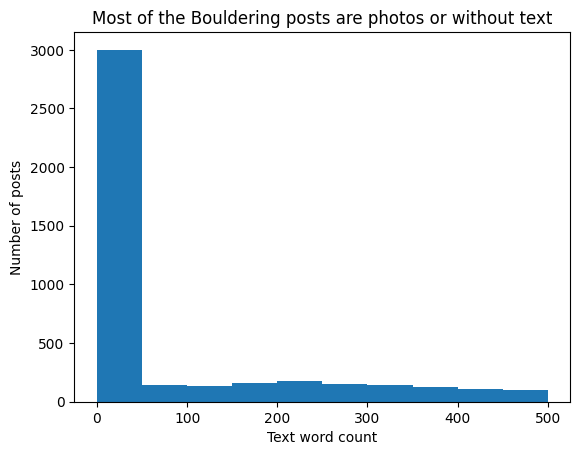

In [19]:
# Plot histogram of bouldering subreddit selftext word count
plt.hist(bd['wordcount'],range=(0,500))
plt.title('Most of the Bouldering posts are photos or without text')
plt.xlabel('Text word count')
plt.ylabel('Number of posts');

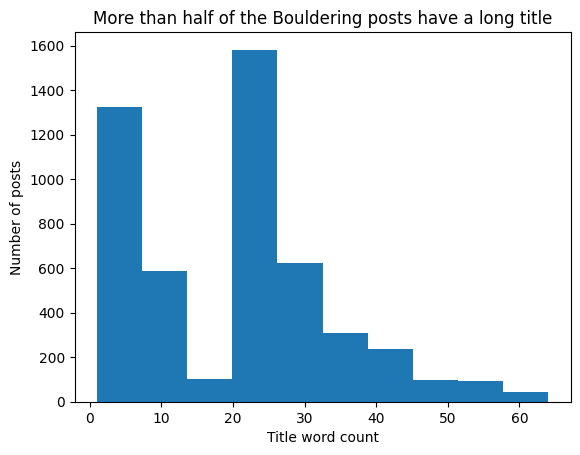

In [20]:
# Plot histogram of bouldering subreddit title word count
plt.hist(bd['titlewordcount'])
plt.title('More than half of the Bouldering posts have a long title')
plt.xlabel('Title word count')
plt.ylabel('Number of posts');

This means that users in Bouldering subreddit generally put more of the context into the title and the body of the posts are usualy photos or videos of their boulder project.

In [21]:
bd[(bd['wordcount']<20) & (bd['titlewordcount']<20)]

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit


There are no post that has title word count and body text word count less than 20 in our data.

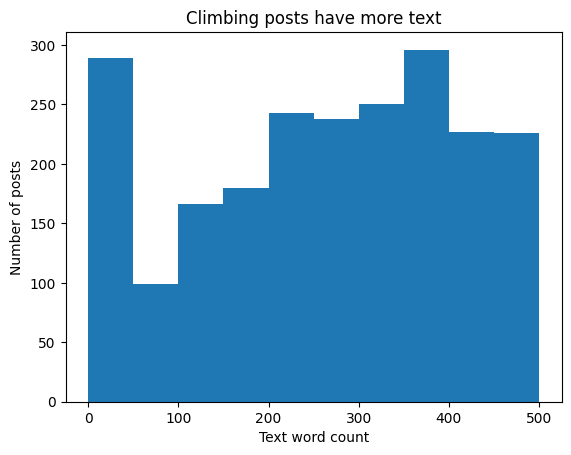

In [22]:
# Plot histogram of climbharder subreddit selftext word count
plt.hist(rc['wordcount'],range=(0,500))
plt.title('Climbing posts have more text')
plt.xlabel('Text word count')
plt.ylabel('Number of posts');

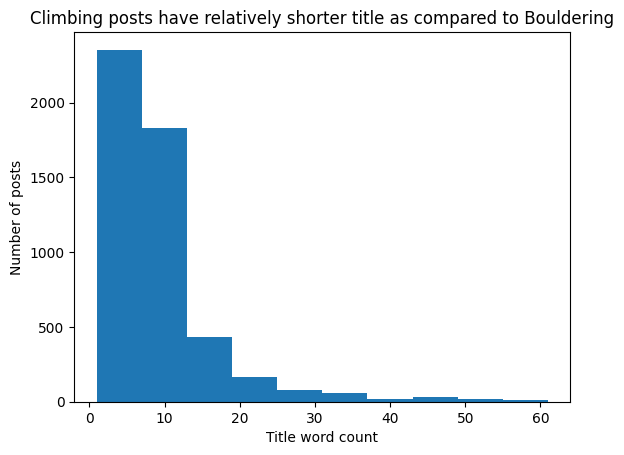

In [23]:
# Plot histogram of climbharder subreddit title word count
plt.hist(rc['titlewordcount'])
plt.title('Climbing posts have relatively shorter title as compared to Bouldering')
plt.xlabel('Title word count')
plt.ylabel('Number of posts');

Users in ClimbHarder subreddit are more expressive in terms of words and hence more word counts in the body of the posts.

In [24]:
rc[(rc['wordcount']<20) & (rc['titlewordcount']<20)]

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit


We made sure there are at least 20 word count in either the 'title' or 'selftext' section to give us sufficient data. In order to make it easier to compare and train the classification model, we are going to combine the 'title' and 'selftext' columns into a single column. The reason is some users tend to explain or comment about a certain topic in the title section itself and upload a photo or video in the post body section. In this case, the title would be able to give us more insights and information about the post.

## Preprocessing

In [25]:
# Concatenate bd and rc into a single DataFrame
allposts = pd.concat([bd,rc])

In [26]:
allposts.shape

(10000, 7)

In [27]:
# Display first 5 rows of allposts
allposts.head()

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit
0,My favorite line from an area I helped develop...,NaN,"['My', 'favorite', 'line', 'from', 'an', 'area...",[],27,0,bouldering
1,This “Features on for feet” problem took a bit...,NaN,"['This', '“Features', 'on', 'for', 'feet”', 'p...",[],20,0,bouldering
2,Finally completed the little ceiling project I...,NaN,"['Finally', 'completed', 'the', 'little', 'cei...",[],22,0,bouldering
3,First overhang send! Also realized from this r...,NaN,"['First', 'overhang', 'send!', 'Also', 'realiz...",[],20,0,bouldering
4,Documenting a mate getting the tick on Bus Sto...,NaN,"['Documenting', 'a', 'mate', 'getting', 'the',...",[],25,0,bouldering


In [28]:
# Fill empty string with Null
allposts.fillna('', inplace=True)

In [29]:
allposts.head()

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit
0,My favorite line from an area I helped develop...,,"['My', 'favorite', 'line', 'from', 'an', 'area...",[],27,0,bouldering
1,This “Features on for feet” problem took a bit...,,"['This', '“Features', 'on', 'for', 'feet”', 'p...",[],20,0,bouldering
2,Finally completed the little ceiling project I...,,"['Finally', 'completed', 'the', 'little', 'cei...",[],22,0,bouldering
3,First overhang send! Also realized from this r...,,"['First', 'overhang', 'send!', 'Also', 'realiz...",[],20,0,bouldering
4,Documenting a mate getting the tick on Bus Sto...,,"['Documenting', 'a', 'mate', 'getting', 'the',...",[],25,0,bouldering


Since title and selftext both contains information regarding each subreddit, we can combine the title and selftext into a single paragraph.

In [30]:
# Combine title and selftext into a column
allposts['combinedtext'] = allposts['title'] + ' ' + allposts['selftext']

In [31]:
# Display last 5 rows
allposts.tail()

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit,combinedtext
4995,Program Feedback,"I wrote a non-periodized program outline, but ...","['Program', 'Feedback']","['I', 'wrote', 'a', 'non-periodized', 'program...",2,1361,climbharder,Program Feedback I wrote a non-periodized prog...
4996,Stuck on last half of one armed pull up,I've been training for the oapu for a while no...,"['Stuck', 'on', 'last', 'half', 'of', 'one', '...","[""I've"", 'been', 'training', 'for', 'the', 'oa...",9,491,climbharder,Stuck on last half of one armed pull up I've b...
4997,Fingers and forearms recovery,I used to powerlift for three years before cli...,"['Fingers', 'and', 'forearms', 'recovery']","['I', 'used', 'to', 'powerlift', 'for', 'three...",4,503,climbharder,Fingers and forearms recovery I used to powerl...
4998,Tendon strength after long break,"Hi everyone,\n\nAs we all know it isn't a very...","['Tendon', 'strength', 'after', 'long', 'break']","['Hi', 'everyone,', 'As', 'we', 'all', 'know',...",5,1173,climbharder,"Tendon strength after long break Hi everyone,\..."
4999,Repeaters everyday ?,Was wondering if anyone had any insight on the...,"['Repeaters', 'everyday', '?']","['Was', 'wondering', 'if', 'anyone', 'had', 'a...",3,345,climbharder,Repeaters everyday ? Was wondering if anyone h...


### Tokenize Data

In [32]:
# Define a function to clean text data (remove whitespace, keep only alphabet characters & make lowercase)

def tokenize_data(data, col):
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_items = [tokenizer.tokenize(item.lower()) for item in data[col]]
    data[f'tokenized_{col}'] = tokenized_items
    return data 

In [33]:
allposts = tokenize_data(allposts, 'combinedtext')
allposts.head()

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit,combinedtext,tokenized_combinedtext
0,My favorite line from an area I helped develop...,,"['My', 'favorite', 'line', 'from', 'an', 'area...",[],27,0,bouldering,My favorite line from an area I helped develop...,"[my, favorite, line, from, an, area, i, helped..."
1,This “Features on for feet” problem took a bit...,,"['This', '“Features', 'on', 'for', 'feet”', 'p...",[],20,0,bouldering,This “Features on for feet” problem took a bit...,"[this, features, on, for, feet, problem, took,..."
2,Finally completed the little ceiling project I...,,"['Finally', 'completed', 'the', 'little', 'cei...",[],22,0,bouldering,Finally completed the little ceiling project I...,"[finally, completed, the, little, ceiling, pro..."
3,First overhang send! Also realized from this r...,,"['First', 'overhang', 'send!', 'Also', 'realiz...",[],20,0,bouldering,First overhang send! Also realized from this r...,"[first, overhang, send, also, realized, from, ..."
4,Documenting a mate getting the tick on Bus Sto...,,"['Documenting', 'a', 'mate', 'getting', 'the',...",[],25,0,bouldering,Documenting a mate getting the tick on Bus Sto...,"[documenting, a, mate, getting, the, tick, on,..."


### Lemmatize Data

In [34]:
# Define a function to lemmatize text data 

def lemmatize_data(data, col):
    lemmatizer = WordNetLemmatizer()
    lemmed_items = []
    for row in data[col]:
        lemmed_row = [lemmatizer.lemmatize(word) for word in row]
        lemmed_items.append(lemmed_row)
    data[f'lemmatized_{col}'] = lemmed_items
    return data  

In [35]:
allposts = lemmatize_data(allposts, 'tokenized_combinedtext')
allposts.head(3)

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit,combinedtext,tokenized_combinedtext,lemmatized_tokenized_combinedtext
0,My favorite line from an area I helped develop...,,"['My', 'favorite', 'line', 'from', 'an', 'area...",[],27,0,bouldering,My favorite line from an area I helped develop...,"[my, favorite, line, from, an, area, i, helped...","[my, favorite, line, from, an, area, i, helped..."
1,This “Features on for feet” problem took a bit...,,"['This', '“Features', 'on', 'for', 'feet”', 'p...",[],20,0,bouldering,This “Features on for feet” problem took a bit...,"[this, features, on, for, feet, problem, took,...","[this, feature, on, for, foot, problem, took, ..."
2,Finally completed the little ceiling project I...,,"['Finally', 'completed', 'the', 'little', 'cei...",[],22,0,bouldering,Finally completed the little ceiling project I...,"[finally, completed, the, little, ceiling, pro...","[finally, completed, the, little, ceiling, pro..."


### Stemmatize Data

In [36]:
# Define a function to stemmatize text data 

def stemmatize_data(data, col):
    p_stemmer = PorterStemmer()
    stemmed_items = []
    for row in data[col]:
        stemmed_row = [p_stemmer.stem(word) for word in row]
        stemmed_items.append(stemmed_row)
    data[f'stemmatized_{col}'] = stemmed_items
    return data  

In [37]:
allposts = stemmatize_data(allposts, 'tokenized_combinedtext')
allposts.head(3)

,title,selftext,splittitle,splitstring,titlewordcount,wordcount,subreddit,combinedtext,tokenized_combinedtext,lemmatized_tokenized_combinedtext,stemmatized_tokenized_combinedtext
0,My favorite line from an area I helped develop...,,"['My', 'favorite', 'line', 'from', 'an', 'area...",[],27,0,bouldering,My favorite line from an area I helped develop...,"[my, favorite, line, from, an, area, i, helped...","[my, favorite, line, from, an, area, i, helped...","[my, favorit, line, from, an, area, i, help, d..."
1,This “Features on for feet” problem took a bit...,,"['This', '“Features', 'on', 'for', 'feet”', 'p...",[],20,0,bouldering,This “Features on for feet” problem took a bit...,"[this, features, on, for, feet, problem, took,...","[this, feature, on, for, foot, problem, took, ...","[thi, featur, on, for, feet, problem, took, a,..."
2,Finally completed the little ceiling project I...,,"['Finally', 'completed', 'the', 'little', 'cei...",[],22,0,bouldering,Finally completed the little ceiling project I...,"[finally, completed, the, little, ceiling, pro...","[finally, completed, the, little, ceiling, pro...","[final, complet, the, littl, ceil, project, i,..."


In [38]:
# Convert subreddit to 0 for post from climbharder and 1 for post from bouldering.
allposts['subreddit'] = allposts['subreddit'].map({'bouldering':1, 'climbharder': 0})

For classification model, we have to change the label from climbharder and bouldering to 0 and 1 respectively.

In [39]:
# Export cleaned data to new csv file
allposts.to_csv('../Data/allposts.csv')